In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np 
import seaborn as sns

In [2]:
df = pd.read_csv('salju_train.csv',usecols=['SuhuMin', 'SuhuMax', 'Penguapan', 'Suhu9am', 'Suhu3pm'],header=0)
df.head()

,SuhuMin,SuhuMax,Penguapan,Suhu9am,Suhu3pm
0,10.4,15.5,NaN,13.1,15.0
1,9.0,17.0,2.6,11.9,15.5
2,18.2,32.0,NaN,23.8,29.6
3,7.3,24.5,8.4,15.3,23.2
4,5.9,20.3,3.6,12.4,18.1


# Pre-Processing

Remove Duplicate

In [3]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum())) #menampilkan jumlah baris yang duplikat

Number of duplicate rows = 585


In [4]:
df = df.drop_duplicates() #drop data yang duplikat
df.describe()

,SuhuMin,SuhuMax,Penguapan,Suhu9am,Suhu3pm
count,107949.000000,108114.000000,61745.000000,107732.000000,106371.000000
mean,12.196376,23.215019,5.465474,16.991518,21.673191
std,6.389445,7.106727,4.208063,6.477803,6.923169
min,-8.500000,-4.800000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,2.600000,12.300000,16.600000
50%,12.000000,22.600000,4.800000,16.700000,21.100000
75%,16.800000,28.200000,7.400000,21.600000,26.400000
max,33.900000,47.300000,145.000000,40.200000,46.700000


Replace Null

jika nilai skewness diantara -2 sampai 2 maka menggunakan mean, jika tidak maka menggunakan median

In [5]:
check_null = df.isnull().sum() #cek jumlah nilai null di tiap kolom
print(check_null)

SuhuMin        561
SuhuMax        396
Penguapan    46765
Suhu9am        778
Suhu3pm       2139
dtype: int64


In [6]:
col = ['SuhuMin', 'SuhuMax', 'Penguapan', 'Suhu9am', 'Suhu3pm'] #menghitung nilai skewness untuk kelima kolom
df[col].skew(axis=0, skipna=True)

SuhuMin      0.018047
SuhuMax      0.221010
Penguapan    3.916798
Suhu9am      0.085141
Suhu3pm      0.237995
dtype: float64

In [7]:
df['SuhuMin'].fillna(df['SuhuMin'].mean(),inplace=True) #ganti nilai null dengan nilai mean
df['SuhuMax'].fillna(df['SuhuMax'].mean(),inplace=True)
df['Penguapan'].fillna(df['Penguapan'].median(),inplace=True) #ganti nilai null dengan nilai median
df['Suhu9am'].fillna(df['Suhu9am'].mean(),inplace=True)
df['Suhu3pm'].fillna(df['Suhu3pm'].mean(),inplace=True)
df.describe()

,SuhuMin,SuhuMax,Penguapan,Suhu9am,Suhu3pm
count,108510.000000,108510.000000,108510.000000,108510.000000,108510.000000
mean,12.196376,23.215019,5.178672,16.991518,21.673191
std,6.372906,7.093747,3.191352,6.454539,6.854592
min,-8.500000,-4.800000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,4.000000,12.300000,16.700000
50%,12.000000,22.700000,4.800000,16.800000,21.300000
75%,16.800000,28.200000,5.200000,21.500000,26.200000
max,33.900000,47.300000,145.000000,40.200000,46.700000


Normalize Data

In [8]:
df = (df - df.min()) / (df.max() - df.min()) #ubah nilai tiap kolom menjadi range 0-1
df.describe()

,SuhuMin,SuhuMax,Penguapan,Suhu9am,Suhu3pm
count,108510.000000,108510.000000,108510.000000,108510.000000,108510.000000
mean,0.488122,0.537716,0.035715,0.510370,0.519639
std,0.150304,0.136156,0.022009,0.136172,0.131566
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.379717,0.435701,0.027586,0.411392,0.424184
50%,0.483491,0.527831,0.033103,0.506329,0.512476
75%,0.596698,0.633397,0.035862,0.605485,0.606526
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df.to_csv('salju_diolah.csv') #untuk download data yang telah diolah

# Pemodelan

Mengambil 2 kolom di dataframe lalu diubah menjadi bentuk array

In [9]:
cluster_df = df[['Suhu9am','Suhu3pm']].copy(deep=True) #dataframe baru dengan 2 kolom
cluster_df.sort_values(by=['Suhu9am','Suhu3pm'], inplace=True)
cluster_arr = np.array(cluster_df) #dataframe diubah menjadi array

Rumus jarak

In [10]:
def count_distance(x1, x2):
    return (sum((x1 - x2) ** 2)) ** 0.5 #rumus menghitung jarak

Fungsi untuk menentukan cluster untuk setiap data

In [11]:
def define_clusters(centroids, cluster_arr):
    clusters = []
    for i in range(cluster_arr.shape[0]): #loop sebanyak jumlah baris
        distances = []
        for centroid in centroids: #loop sebanyak jumlah centroid sesuai dengan nilai K
            distances.append(count_distance(centroid, cluster_arr[i])) #menghitung distance dari tiap data dengan semua centroid
        cluster = [x for x, val in enumerate(distances) if val == min(distances)] #mencari centroid terdekat
        clusters.append(cluster[0]) #menentukan cluster
    return np.array(clusters)

Fungsi untuk menentukan centroid baru untuk setiap cluster

In [12]:
def count_centroids(clusters, cluster_arr):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(cluster_arr), pd.DataFrame(clusters, columns=['cluster'])], axis=1) #menggabungkan dataframe
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0) #mencari mean dari cluster
        new_centroids.append(cluster_mean) #mean tersebut menjadi centroid baru dalam cluster tersebut
    return np.array(new_centroids)

Main program

In [13]:
k = 3 #menentukan jumlah cluster
centroids = [cluster_arr[i+2] for i in range(k)] #random centroid awal
clusters = define_clusters(centroids, cluster_arr) #menentukan cluster berdasarkan centroid awal
initial_clusters = clusters
for i in range(20): #loop untuk mengulangi proses penentuan centroid dan penentuan cluster
    centroids = count_centroids(clusters, cluster_arr)
    clusters = define_clusters(centroids, cluster_arr)

Visualisasi clustering

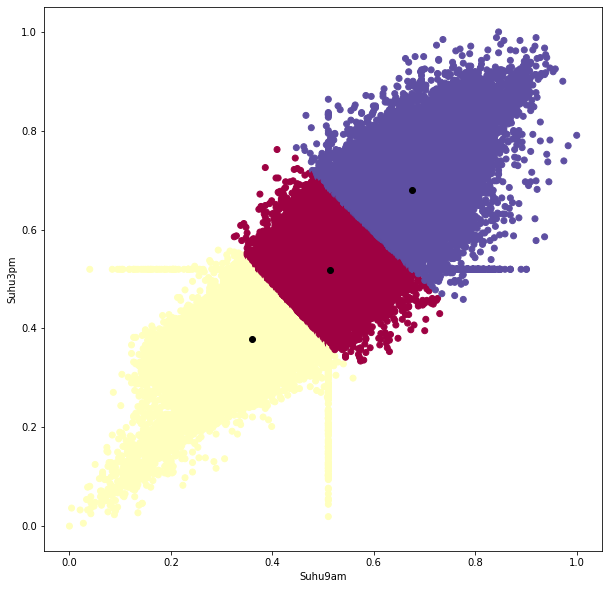

In [14]:
plt.subplots(figsize=(10,10))
plt.scatter(x=cluster_arr[:,0], y=cluster_arr[:,1], 
            c=clusters, cmap=plt.cm.Spectral);
plt.scatter(x=centroids[:,0], y=centroids[:,1], color='black');
plt.xlabel('Suhu9am')
plt.ylabel('Suhu3pm');

# Evaluasi

Algoritma elbow method dengan 2 cara yakni distortion dan inertia

In [15]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
distortions = []
inertias = []
K = range(1, 11) #menentukan range K yang akan diuji
X = cluster_arr
 
for k in K:
    kmean_model = KMeans(n_clusters=k).fit(X)
    kmean_model.fit(X)
    distortions.append(sum(np.min(cdist(X, kmean_model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]) #menghitung nilai distortion untuk setiap nilai K
    inertias.append(kmean_model.inertia_) #menghitung nilai inertia untuk setiap nilai K

Visualisasi data elbow method menggunakan distortion

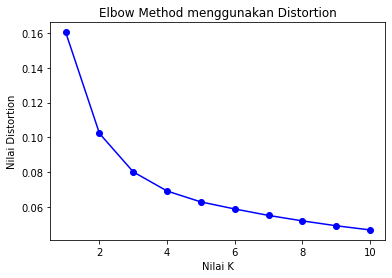

In [16]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('Nilai K')
plt.ylabel('Nilai Distortion')
plt.title('Elbow Method menggunakan Distortion')
plt.show()

Visualisasi data elbow method menggunakan inertia

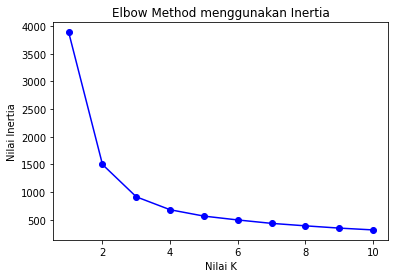

In [17]:

plt.plot(K, inertias, 'bo-')
plt.xlabel('Nilai K')
plt.ylabel('Nilai Inertia')
plt.title('Elbow Method menggunakan Inertia')
plt.show()